In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install scikit-learn numpy pandas matplotlib
import numpy as np, pandas as pd, json, pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE = "/content/drive/MyDrive"

def load_pred(path):
    df = pd.read_csv(path, header=None)

    # keep only the last column (some files may have y_true + y_pred)
    if df.shape[1] > 1:
        df = df.iloc[:, -1]

    # drop header-like text if present and coerce to numeric
    pred = pd.to_numeric(df.squeeze('columns'), errors='coerce')

    # trim or pad so length matches y
    if len(pred) > len(y):
        pred = pred.tail(len(y)).reset_index(drop=True)
    elif len(pred) < len(y):
        raise ValueError(f"{path} shorter than y_val")

    return pred.astype(float)          # ensure dtype float


print("Lengths:", len(b), len(t), len(c), len(y))   # should be 760 760 760 760


Lengths: 760 760 760 760


In [ ]:
b = load_pred(f"{DRIVE}/pred_bi_gru.csv")
t = load_pred(f"{DRIVE}/pred_transformer.csv")
c = load_pred(f"{DRIVE}/pred_tcn.csv")

print("Dtypes:", b.dtype, t.dtype, c.dtype)   # should be float64


Dtypes: float64 float64 float64


In [ ]:
def rmse(pred, true=y):
    return float(np.sqrt(np.mean((pred - true) ** 2)))

def dir_acc(pred, true=y):
    # convert to plain NumPy arrays → avoid index-alignment issues
    p = np.asarray(pred)
    t = np.asarray(true)
    return float(np.mean(np.sign(p[1:] - p[:-1]) ==
                         np.sign(t[1:] - t[:-1])))

metrics = {
    "bgru"       : {"rmse": rmse(b), "dir_acc": dir_acc(b)},
    "transformer": {"rmse": rmse(t), "dir_acc": dir_acc(t)},
    "tcn"        : {"rmse": rmse(c), "dir_acc": dir_acc(c)},
}
print(pd.DataFrame(metrics).T)



                 rmse   dir_acc
bgru         0.067459  0.492754
transformer  0.148027  0.527009
tcn          0.812891  0.513834


In [ ]:
import numpy as np
from sklearn.linear_model import Ridge

# Cast once to NumPy arrays
b_np, t_np, c_np = map(np.asarray, (b, t, c))

# 1. Simple mean
mean_pred = (b_np + t_np + c_np) / 3

# 2. RMSE-weighted mean  (drop a model if its error is >2× best)
rmse_vals = np.array([metrics[m]["rmse"] for m in ["bgru", "transformer", "tcn"]])
best_rmse = rmse_vals.min()
use_mask  = rmse_vals < 2 * best_rmse        # boolean mask
weights   = (1 / rmse_vals[use_mask])
weights   = weights / weights.sum()
rmse_w_pred = weights.dot(np.vstack([b_np, t_np, c_np])[use_mask])

# 3. Ridge meta-learner
ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(np.vstack([b_np, t_np, c_np]).T, y)
ridge_pred = ridge.predict(np.vstack([b_np, t_np, c_np]).T)

candidates = {
    "mean"         : mean_pred,
    "rmse_weighted": rmse_w_pred,
    "ridge"        : ridge_pred,
}


In [ ]:
for name, pred in candidates.items():
    metrics[name] = {
        "rmse"    : rmse(pred),
        "dir_acc" : dir_acc(pred),
    }

best_name, best_pred = min(
    candidates.items(), key=lambda kv: metrics[kv[0]]["rmse"]
)
metrics["chosen"] = best_name

print("Best fusion →", best_name,
      "| RMSE:", round(metrics[best_name]["rmse"], 4),
      "| DirAcc:", round(metrics[best_name]["dir_acc"], 3))
pd.DataFrame(metrics).T


Best fusion → ridge | RMSE: 0.0622 | DirAcc: 0.493


,rmse,dir_acc
bgru,0.067459,0.492754
transformer,0.148027,0.527009
tcn,0.812891,0.513834
mean,0.257966,0.501976
rmse_weighted,0.067459,0.492754
ridge,0.062246,0.492754
chosen,ridge,ridge


In [ ]:
import json, pandas as pd, os

# Ensure output folder exists
os.makedirs(DRIVE, exist_ok=True)

# 1. Ensemble predictions (scaled)
pd.DataFrame(best_pred).to_csv(f"{DRIVE}/ensemble_pred.csv",
                               index=False, header=False)

# 2. Metrics JSON
with open(f"{DRIVE}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved ensemble_pred.csv and metrics.json to Drive")


Saved ensemble_pred.csv and metrics.json to Drive


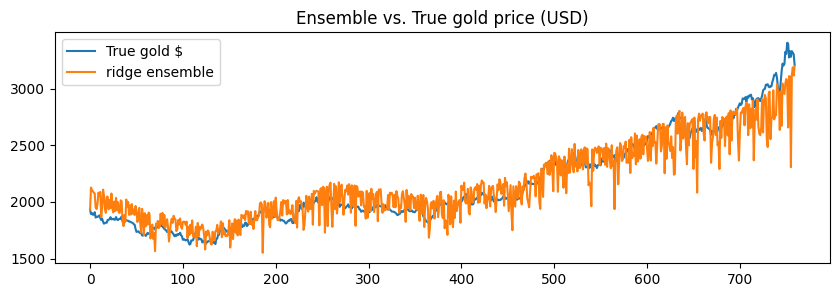

In [ ]:
import matplotlib.pyplot as plt, pickle
scaler = pickle.load(open(f"{DRIVE}/scaler.pkl", "rb"))
g_idx  = list(scaler.feature_names_in_).index("GC=F")
vmin, vmax = scaler.data_min_[g_idx], scaler.data_max_[g_idx]

to_real = lambda arr: arr * (vmax - vmin) + vmin
plt.figure(figsize=(10,3))
plt.plot(to_real(y),         label="True gold $")
plt.plot(to_real(best_pred), label=f"{best_name} ensemble")
plt.title("Ensemble vs. True gold price (USD)")
plt.legend(); plt.show()

In [ ]:
import pprint, json, pathlib, pandas as pd
pprint.pprint(metrics)


{'bgru': {'dir_acc': 0.4927536231884058, 'rmse': 0.0674593360079881},
 'chosen': 'ridge',
 'mean': {'dir_acc': 0.5019762845849802, 'rmse': 0.2579660170360527},
 'ridge': {'dir_acc': 0.4927536231884058, 'rmse': 0.062245599879262856},
 'rmse_weighted': {'dir_acc': 0.4927536231884058, 'rmse': 0.0674593360079881},
 'tcn': {'dir_acc': 0.5138339920948617, 'rmse': 0.8128908168058169},
 'transformer': {'dir_acc': 0.5270092226613966, 'rmse': 0.1480273580152656}}
